Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xg
from google.colab import files

Load and Audit the data

In [ ]:
bm_data=pd.read_csv('https://datahack-prod.s3.amazonaws.com/train_file/train_v9rqX0R.csv')
bm_tdata= pd.read_csv('https://datahack-prod.s3.amazonaws.com/test_file/test_AbJTz2l.csv')

In [ ]:
bm_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052



1.   Data contains 8523 rows and 12 columns
2.   Out of 12 column,**Item_Weight** and **Outlet_Size** has null values which needs to be imputed
3.   Out of 12 column, 6 columns are of object type which needs to encoded to numeric



In [ ]:
bm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


1. **Item_Outlet_Sales** is positively skewed as mean is greater than median
2. We can observe 75% of sales is below 3101.29 but maximum sales value is 13086.

In [ ]:
bm_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:
bm_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
bm_data[bm_data['Item_Visibility']==0].Item_Type.unique()

array(['Fruits and Vegetables', 'Household', 'Baking Goods',
       'Snack Foods', 'Breads', 'Health and Hygiene', 'Starchy Foods',
       'Canned', 'Frozen Foods', 'Meat', 'Dairy', 'Soft Drinks', 'Others',
       'Hard Drinks', 'Breakfast', 'Seafood'], dtype=object)

Data Imputaion 

> We will impute Item_Weight with mean of Item_weight aggregated on Item_Identifier

> We will impute Outlet_Size with mode of Item_weight aggregated on Outlet_Type





In [ ]:
miss_val= bm_data['Item_Weight'].isnull()

In [ ]:
bm_data[pd.isnull(bm_data["Item_Weight"])].Item_Identifier.unique()

array(['FDP10', 'DRI11', 'FDW12', ..., 'FDQ58', 'DRG13', 'NCN18'],
      dtype=object)

In [ ]:
def dataImpute(dt):
  for i in dt[pd.isnull(dt["Item_Weight"])].Item_Identifier.unique():
    dictVal=i
    #print(dictVal)
    m1=(dt["Item_Identifier"] == dictVal)
    dt.loc[m1,"Item_Weight"] = dt.loc[m1,"Item_Weight"].fillna(dt.loc[m1, "Item_Weight"].mean())

  dt['Item_Weight']=np.where(dt['Item_Weight'].isna(),dt['Item_Weight'].mean(skipna=True),dt['Item_Weight'])

  for i in dt[pd.isnull(dt["Outlet_Size"])].Outlet_Type.unique():
    dictVal=i
    #print(dictVal)
    m1=(dt["Outlet_Type"] == dictVal)
    dt.loc[m1,"Outlet_Size"] = dt.loc[m1,"Outlet_Size"].fillna(dt.loc[m1, "Outlet_Size"].mode()[0])

  dt.replace({'Item_Fat_Content':{'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)

  for i in dt[bm_data["Item_Visibility"]==0].Item_Type.unique():
    dictVal=i
    #print(dictVal)
    m1=(dt["Item_Type"] == dictVal)
    m2=((dt["Item_Type"] == dictVal) & (bm_data["Item_Visibility"]==0))
    dt.loc[m2,"Item_Visibility"] = (dt.loc[m1, "Item_Visibility"].mean())
  
#bm_data.loc[bm_data['Item_Type']=='Fruits and Vegetables',"Item_Visibility"].mean()



In [ ]:

#bm_data.loc[(bm_data['Item_Type']=='Dairy') & (bm_data["Item_Visibility"]==0)
 #=bm_data.loc[bm_data['Item_Type']=='Fruits and Vegetables',"Item_Visibility"].mean()

In [ ]:
# Imputing train and test data
dataImpute(bm_data) #train
dataImpute(bm_tdata) #test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
#for i in bm_data[pd.isnull(bm_data["Item_Weight"])].Item_Identifier.unique():
  #dictVal=i
  #print(dictVal)
  #m1=(bm_data["Item_Identifier"] == dictVal)
  #bm_data.loc[m1,"Item_Weight"] = bm_data.loc[m1,"Item_Weight"].fillna(bm_data.loc[m1, "Item_Weight"].mean())



In [ ]:
#bm_data['Item_Weight']=np.where(bm_data['Item_Weight'].isna(),bm_data['Item_Weight'].mean(skipna=True),bm_data['Item_Weight'])

In [ ]:
bm_tdata.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [ ]:
print(bm_data[pd.isnull(bm_data["Outlet_Size"])].Outlet_Type.unique())

[]


In [ ]:
#for i in bm_data[pd.isnull(bm_data["Outlet_Size"])].Outlet_Type.unique():
  #dictVal=i
  #print(dictVal)
  #m1=(bm_data["Outlet_Type"] == dictVal)
  #bm_data.loc[m1,"Outlet_Size"] = bm_data.loc[m1,"Outlet_Size"].fillna(bm_data.loc[m1, "Outlet_Size"].mode()[0])


In [ ]:
print(bm_data[bm_data['Outlet_Type']=='Supermarket Type1'].Outlet_Size.unique())

['Medium' 'High' 'Small']


**Data Visualisation**

In [ ]:
sns.set()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


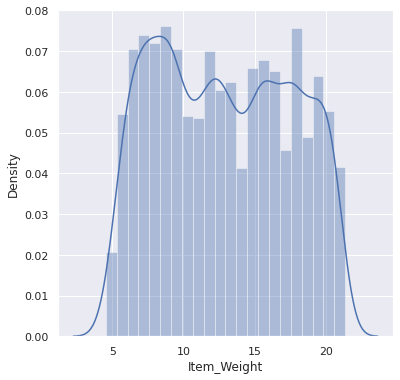

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_Weight'])
plt.show()

From Distplot, we can infer that weight are fairly distributed.
Large no products have weight range between 5 to 9 and 13 to 14.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


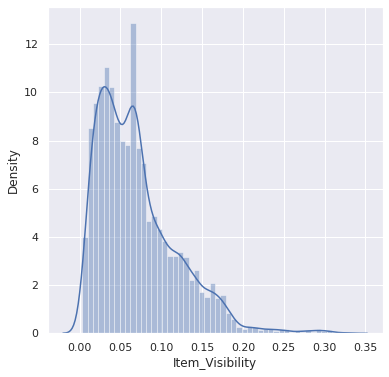

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_Visibility'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


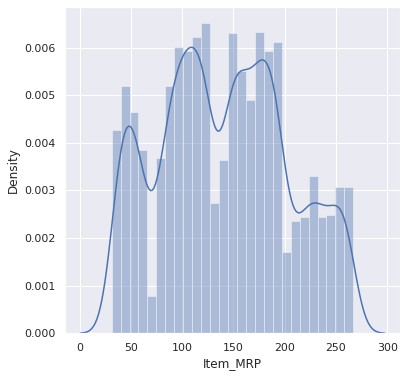

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_MRP'])
plt.show()

Price of most of the products lies within range of 100 to 200.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


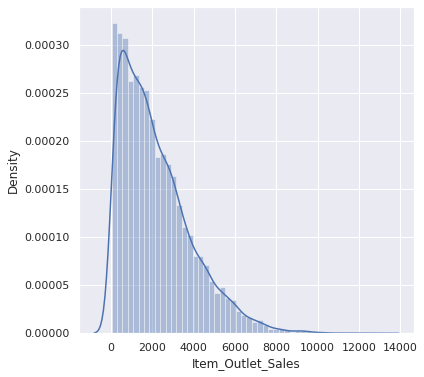

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(bm_data['Item_Outlet_Sales'])
plt.show()

Sales is right skewed. Some of the products have very high Sale.

In [ ]:
bm_data[bm_data['Item_Outlet_Sales']>13000]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7188,NCE42,21.1,Low Fat,0.010551,Household,234.9958,OUT027,1985,Medium,Tier 3,Supermarket Type3,13086.9648


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


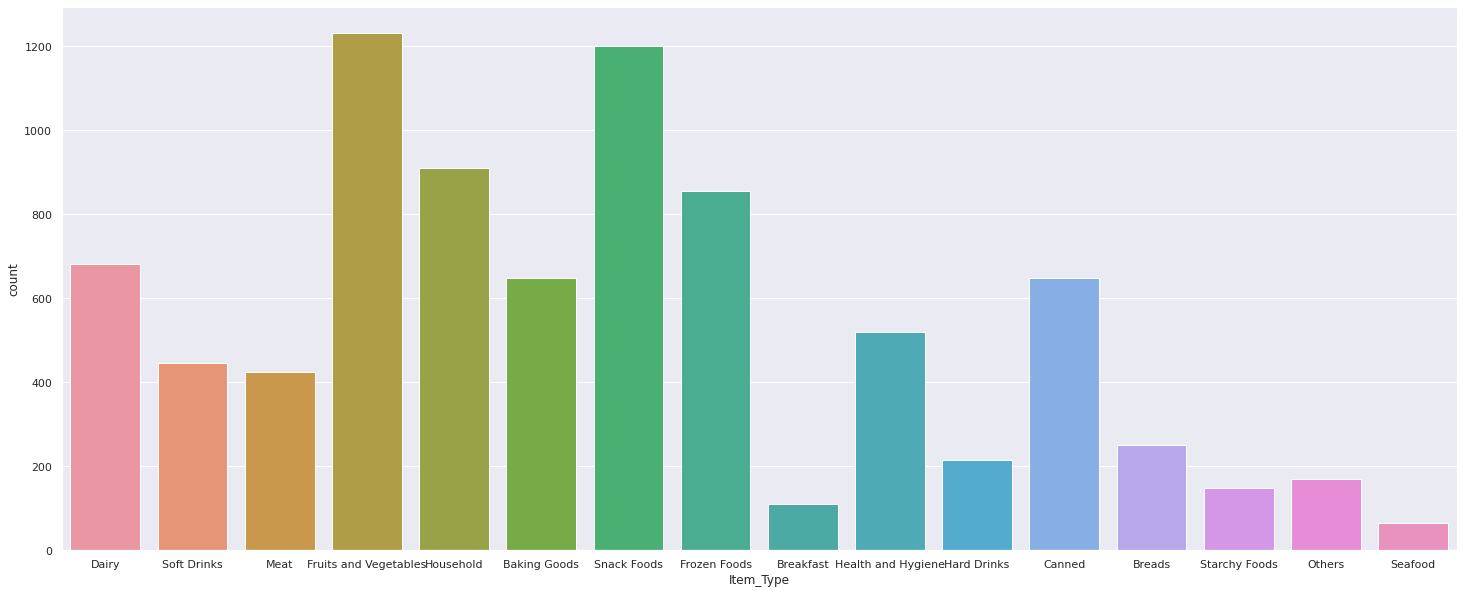

In [ ]:
plt.figure(figsize=(25,10))
sns.countplot(bm_data['Item_Type'])
plt.show()

Large no of product falls under item categories **Fruits and Vegetables ** and **Snack Foods** 

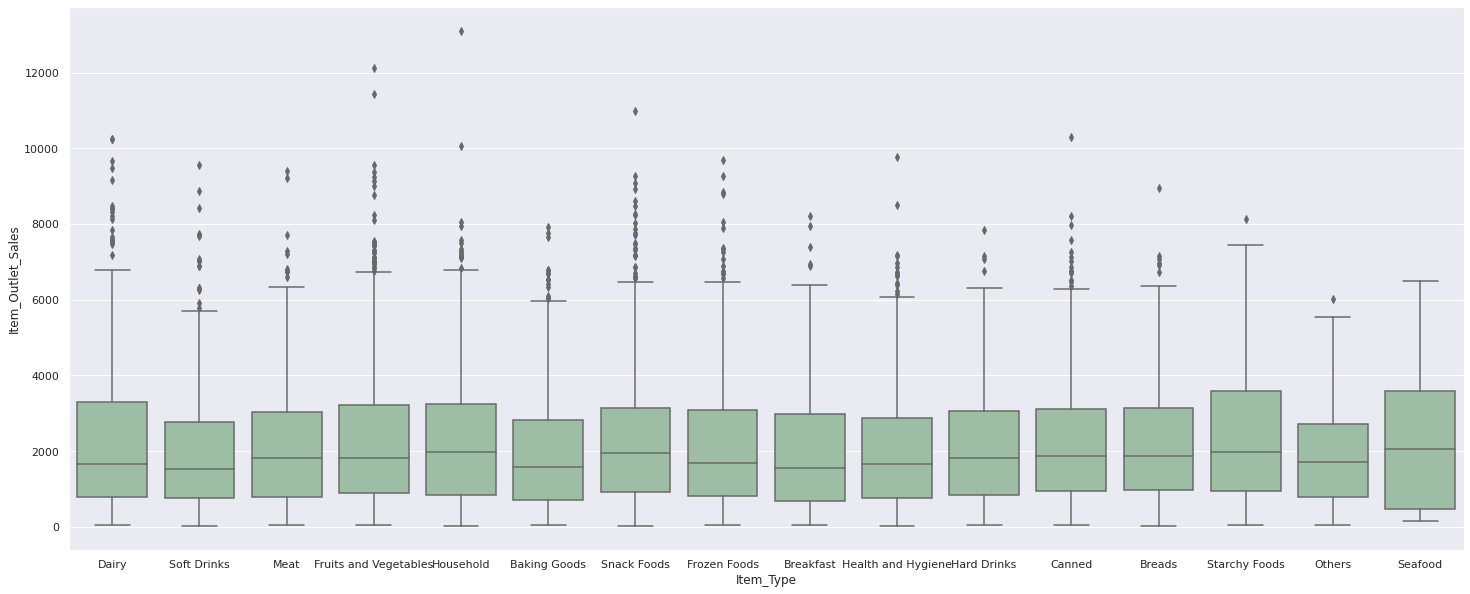

In [ ]:
plt.figure(figsize=(25,10))
ax = sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=bm_data, color='#99c2a2')
#ax = sns.boxplot(x='Item_Weight', y='Item_Outlet_Sales', data=df, color='#99c2a2')
#ax = sns.swarmplot(x="Outlet_Location_Type", y="Item_Outlet_Sales", data=df, color='#7d0013')
#df.plot.scatter(x='Item_Fat_Content', y='Item_Outlet_Sales', marker='o', figsize=(7,5))
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 720x720 with 0 Axes>

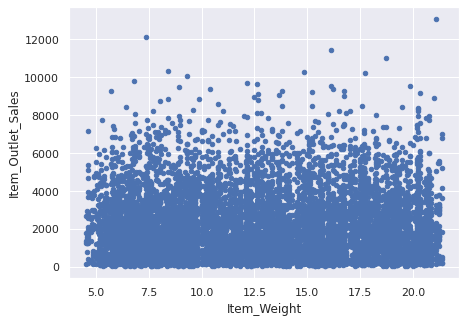

In [ ]:
plt.figure(figsize=(10,10))
#ax = sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=bm_data, color='#99c2a2')
#ax = sns.boxplot(x='Item_Weight', y='Item_Outlet_Sales', data=df, color='#99c2a2')
#ax = sns.swarmplot(x="Outlet_Location_Type", y="Item_Outlet_Sales", data=df, color='#7d0013')
bm_data.plot.scatter(x='Item_Weight', y='Item_Outlet_Sales', marker='o', figsize=(7,5))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


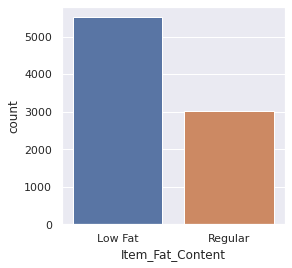

In [ ]:
plt.figure(figsize=(4,4))
sns.countplot(bm_data['Item_Fat_Content'])
plt.show()

Replace low fat and LF to Low Fat and reg to Regular

In [ ]:
bm_data.replace({'Item_Fat_Content':{'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)

Encoding the Object features to Numeric

In [ ]:
le = LabelEncoder()
ile= LabelEncoder()
ole = LabelEncoder()
def dataEncoding(dt):
  
  dt['Item_Identifier'] = ile.fit_transform(dt['Item_Identifier'])
  #le = LabelEncoder()
  dt['Item_Type'] = le.fit_transform(dt['Item_Type'])
  #le = LabelEncoder()
  dt['Outlet_Type'] = le.fit_transform(dt['Outlet_Type'])
  #le = LabelEncoder()
  dt['Outlet_Location_Type'] = le.fit_transform(dt['Outlet_Location_Type'])
  #le = LabelEncoder()
  dt['Item_Fat_Content'] = le.fit_transform(dt['Item_Fat_Content'])
  #le = LabelEncoder()
  dt['Outlet_Size'] = le.fit_transform(dt['Outlet_Size'])
  dt['Outlet_Identifier'] = ole.fit_transform(dt['Outlet_Identifier'])

In [ ]:
#Encoding of train and test data
dataEncoding(bm_data)
dataEncoding(bm_tdata)

In [ ]:
bm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   int64  
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   int64  
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   int64  
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   int64  
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   int64  
 9   Outlet_Location_Type       8523 non-null   int64  
 10  Outlet_Type                8523 non-null   int64  
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 799.2 KB


In [ ]:
#print(bm_data[bm_data['Outlet_Type']=='Supermarket Type1'].Outlet_Size.unique())
print(bm_data[bm_data['Outlet_Type']=='Grocery Store'].Outlet_Location_Type.unique())

[]


In [ ]:
bm_data.corr()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,1.000000,0.048281,-0.114660,-0.031655,-0.017973,0.012853,-0.008602,-0.012772,0.001229,0.003656,-0.001178,0.002869
Item_Weight,0.048281,1.000000,-0.026788,-0.017862,0.035688,0.025972,-0.007591,-0.013418,-0.012424,0.002937,0.000537,0.013165
Item_Fat_Content,-0.114660,-0.026788,1.000000,0.051586,-0.139434,0.006063,0.000764,0.003151,-0.001262,-0.001598,0.002199,0.018719
Item_Visibility,-0.031655,-0.017862,0.051586,1.000000,-0.038038,-0.005061,-0.106127,-0.078236,0.097479,-0.028046,-0.179493,-0.133940
Item_Type,-0.017973,0.035688,-0.139434,-0.038038,1.000000,0.032651,0.001656,0.004970,-0.000218,0.003084,0.003053,0.017048
Item_MRP,0.012853,0.025972,0.006063,-0.005061,0.032651,1.000000,0.003319,0.005020,0.000872,0.000232,-0.001975,0.567574
Outlet_Identifier,-0.008602,-0.007591,0.000764,-0.106127,0.001656,0.003319,1.000000,0.079035,0.260272,-0.716176,0.099873,0.162325
Outlet_Establishment_Year,-0.012772,-0.013418,0.003151,-0.078236,0.004970,0.005020,0.079035,1.000000,0.425534,-0.089216,-0.122304,-0.049135
Outlet_Size,0.001229,-0.012424,-0.001262,0.097479,-0.000218,0.000872,0.260272,0.425534,1.000000,-0.480075,-0.401373,-0.162753
Outlet_Location_Type,0.003656,0.002937,-0.001598,-0.028046,0.003084,0.000232,-0.716176,-0.089216,-0.480075,1.000000,0.467219,0.089367


In [ ]:
bm_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228


In [ ]:
train_data=bm_data.drop(['Item_Weight','Item_Type','Outlet_Establishment_Year'],axis=1)
train_tdata=bm_tdata.drop(['Item_Weight','Item_Type','Outlet_Establishment_Year'],axis=1)

In [ ]:
bm_data[bm_data['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [ ]:
x = train_data.iloc[:,0:8]
y=bm_data['Item_Outlet_Sales']

In [ ]:
print(x.shape)
x.info()

(8523, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Identifier       8523 non-null   int64  
 1   Item_Fat_Content      8523 non-null   int64  
 2   Item_Visibility       8523 non-null   float64
 3   Item_MRP              8523 non-null   float64
 4   Outlet_Identifier     8523 non-null   int64  
 5   Outlet_Size           8523 non-null   int64  
 6   Outlet_Location_Type  8523 non-null   int64  
 7   Outlet_Type           8523 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 532.8 KB


In [ ]:
print(np.unique(bm_data[['Outlet_Size', 'Outlet_Type']].values))

[0 1 2 3]


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=123)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5966, 8)
(2557, 8)
(5966,)
(2557,)


In [ ]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_hat=lr.predict(x_test)
y_test_hat = lr.predict(train_tdata) # predict test data

In [ ]:
y_hats_df = pd.DataFrame(data = y_test_hat, columns = ['y_test_hat'], index = train_tdata.index.copy())
df_out = pd.merge(train_tdata, y_hats_df, how = 'left', left_index = True, right_index = True)

In [ ]:
df_out['Item_Identifier']=ile.inverse_transform(df_out['Item_Identifier'])
df_out['Outlet_Identifier']=ole.inverse_transform(df_out['Outlet_Identifier'])

In [ ]:
df_out.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Identifier       5681 non-null   object 
 1   Item_Fat_Content      5681 non-null   int64  
 2   Item_Visibility       5681 non-null   float64
 3   Item_MRP              5681 non-null   float64
 4   Outlet_Identifier     5681 non-null   object 
 5   Outlet_Size           5681 non-null   int64  
 6   Outlet_Location_Type  5681 non-null   int64  
 7   Outlet_Type           5681 non-null   int64  
 8   y_test_hat            5681 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 399.6+ KB


In [ ]:
df_out.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,y_test_hat
0,FDW58,0,0.007565,107.8622,OUT049,1,0,1,2005.109548
1,FDW14,1,0.038428,87.3198,OUT017,2,1,1,1095.194657
2,NCN55,0,0.099575,241.7538,OUT010,2,2,0,2290.053002
3,FDQ58,0,0.015388,155.0340,OUT017,2,1,1,2107.248941
4,FDY38,1,0.118599,234.2300,OUT027,1,2,3,5037.412643


In [ ]:
print(lr.intercept_)
print(lr.coef_)

-858.3142482646872
[ 2.01251309e-02  6.99492335e+01 -1.74885314e+03  1.54606194e+01
  5.51202384e+01 -1.20899879e+02 -1.00825267e+02  8.11656872e+02]


In [ ]:
def model_eval(actual,predicted):
    rmse = np.sqrt(mean_squared_error(actual,predicted))
    r_score = r2_score(actual,predicted)
    print('The Root Mean Squared Error is ' , rmse)
    print(' The R squared for model is ',r_score)

In [ ]:
# For train data evaluation
model_eval(y_test,y_hat)

The Root Mean Squared Error is  1202.6816059480725
 The R squared for model is  0.5211358062048359


In [ ]:
# For test data evaluation

In [ ]:
xgb_r=xg.XGBRegressor()
xgb_r.fit(x_train,y_train)
pred = xgb_r.predict(x_train)
x_test_pred=xgb_r.predict(train_tdata)

[11:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Train Prediction and Evaluation

In [ ]:
model_eval(y_train,pred)

The Root Mean Squared Error is  1027.312837086198
 The R squared for model is  0.6316288645702905


Test Prediction and Evaluation

In [ ]:
pred_test = xgb_r.predict(x_test)
model_eval(y_test,pred_test)

The Root Mean Squared Error is  1087.89474787507
 The R squared for model is  0.6081816357965102


In [ ]:
y_xgtest_df = pd.DataFrame(data = x_test_pred, columns = ['x_test_pred'], index = train_tdata.index.copy())
df_xg_out = pd.merge(train_tdata, y_xgtest_df, how = 'left', left_index = True, right_index = True)

In [ ]:
df_xg_out['Item_Identifier']=ile.inverse_transform(df_xg_out['Item_Identifier'])
df_xg_out['Outlet_Identifier']=ole.inverse_transform(df_xg_out['Outlet_Identifier'])

In [ ]:
train_tdata.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,1103,0,0.007565,107.8622,9,1,0,1
1,1067,1,0.038428,87.3198,2,2,1,1
2,1406,0,0.099575,241.7538,0,2,2,0
3,809,0,0.015388,155.0340,2,2,1,1
4,1184,1,0.118599,234.2300,5,1,2,3


In [ ]:
df_test_pred=df_xg_out[['Item_Identifier','Outlet_Identifier','x_test_pred']].copy()

In [ ]:
df_test_pred.rename(columns = {'x_test_pred':'Item_Outlet_Sales'}, inplace = True)

In [ ]:
df_test_pred.to_csv("Item_Sales.csv")
files.download("Item_Sales.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>